In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Importing the libraries we need

In [ ]:
#!pip install transformers -q
!pip install wandb -q
!pip install sentencepiece

!pip install transformers==2.9.0 
!pip install pytorch_lightning==0.7.5
# Code for TPU packages install
# !curl -q https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

In [ ]:
# Importing stock libraries
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

# WandB – Import the wandb library
import wandb

In [ ]:
# # Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# Preparing for TPU usage
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

In [ ]:

# Login to wandb to log the model run and all the parameters
!wandb login

wandb: Currently logged in as: emr (use `wandb login --relogin` to force relogin)


# Preparing function to prepare our data for fine tuning

In [ ]:

# Creating a custom dataset for reading the dataframe and loading it into the dataloader to pass it to the neural network at a later stage for finetuning the model and to prepare it for predictions

class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, source_len, summ_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = summ_len
        self.text = self.data.text
        self.ctext = self.data.ctext

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        ctext = str(self.ctext[index])
        ctext = ' '.join(ctext.split())

        text = str(self.text[index])
        text = ' '.join(text.split())

        source = self.tokenizer.batch_encode_plus([ctext], max_length= self.source_len, pad_to_max_length=True,return_tensors='pt')
        target = self.tokenizer.batch_encode_plus([text], max_length= self.summ_len, pad_to_max_length=True,return_tensors='pt')

        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids': source_ids.to(dtype=torch.long), 
            'source_mask': source_mask.to(dtype=torch.long), 
            'target_ids': target_ids.to(dtype=torch.long),
            'target_ids_y': target_ids.to(dtype=torch.long)
        }

In [ ]:
# Creating the training function. This will be called in the main function. It is run depending on the epoch value.
# The model is put into train mode and then we wnumerate over the training loader and passed to the defined network 

def train(epoch, tokenizer, model, device, loader, optimizer):
    model.train()
    for _,data in enumerate(loader, 0):
        y = data['target_ids'].to(device, dtype = torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)

        outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, lm_labels=lm_labels)
        loss = outputs[0]
        
        if _%10 == 0:
            wandb.log({"Training Loss": loss.item()})

        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # xm.optimizer_step(optimizer)
        # xm.mark_step()

In [ ]:
def validate(epoch, tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actuals = []
    hsum = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = ids,
                num_beams=4,
                no_repeat_ngram_size=2,
                min_length=30,
                max_length=85,
                early_stopping=True)
            
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _%100==0:
                print(f'Completed {_}')

            predictions.extend(preds)
            actuals.extend(target)
            
    return predictions, actuals

# The fine tuning

The dataset is imported as a dataframe and give it the headers as per the documentation.
A new string is added to the main article column summarize: prior to the actual article. This is done because T5 had similar formatting for the summarization dataset.
The final Dataframe should be something like this according to the creator of the algorithm:

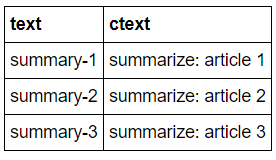


Top 5 rows of the dataframe are printed on the console.

In [ ]:
pd.options.display.max_colwidth = 300

In [ ]:

# WandB – Initialize a new run
wandb.init(project="Finetune_T5_REDDIT_TIFU")

# WandB – Config is a variable that holds and saves hyperparameters and inputs
# Defining some key variables that will be used later on in the training  
config = wandb.config          # Initialize config
config.TRAIN_BATCH_SIZE = 2    # input batch size for training (default: 64)
config.VALID_BATCH_SIZE = 2    # input batch size for testing (default: 1000)
config.TRAIN_EPOCHS = 10       # number of epochs to train (default: 10)
config.VAL_EPOCHS = 1 
config.LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
config.SEED = 42               # random seed (default: 42)
config.MAX_LEN = 512
config.SUMMARY_LEN = 150       #We put 150 to limit the summary length

# Set random seeds and deterministic pytorch for reproducibility
torch.manual_seed(config.SEED) # pytorch random seed
np.random.seed(config.SEED) # numpy random seed
torch.backends.cudnn.deterministic = True

# tokenzier for encoding the text
tokenizer = T5Tokenizer.from_pretrained("t5-base")
    

# Importing and Pre-Processing the domain data
# Selecting the needed columns only. 
# Adding the summarzie text in front of the text. This is to format the dataset similar to how T5 model was trained for summarization task. 
#reddit20 = "/content/gdrive/MyDrive/MasterThesis/reddit100_clean.csv"
reddit100 = "/content/gdrive/MyDrive/UPM_ALUMNOS_2021/MasterThesis/reddit100_clean.csv"
df = pd.read_csv(reddit100, thousands  = ',',encoding='latin-1')


df.rename(columns = {'content':'ctext', 'summary':'text'}, inplace = True)
df = df[['text','ctext']]
df.ctext = 'summarize: ' + df.ctext
print(df.head())

    
# Creation of Dataset and Dataloader
# Defining the train size. So 80% of the data will be used for training and the rest will be used for validation. 
train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state = config.SEED)
val_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(val_dataset.shape))


# Creating the Training and Validation dataset for further creation of Dataloader
training_set = CustomDataset(train_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)
val_set = CustomDataset(val_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)

# Defining the parameters for creation of dataloaders
train_params = {
    'batch_size': config.TRAIN_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
    }

val_params = {
    'batch_size': config.VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
    }

# Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
training_loader = DataLoader(training_set, **train_params)
val_loader = DataLoader(val_set, **val_params)


    
# Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary. 
# Further this model is sent to device (GPU/TPU) for using the hardware.
model = T5ForConditionalGeneration.from_pretrained("t5-base")
model = model.to(device)

# Defining the optimizer that will be used to tune the weights of the network in the training session. 
optimizer = torch.optim.Adam(params =  model.parameters(), lr=config.LEARNING_RATE)

# Log metrics with wandb
wandb.watch(model, log="all")
# Training loop
print('Initiating Fine-Tuning for the model on our dataset')

for epoch in range(config.TRAIN_EPOCHS):
    train(epoch, tokenizer, model, device, training_loader, optimizer)


# Validation loop and saving the resulting file with predictions and acutals in a dataframe.
# Saving the dataframe as predictions.csv
print('Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe')
for epoch in range(config.VAL_EPOCHS):
    predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
    final_df = pd.DataFrame({'Generated summary':predictions,'Human Summary':actuals})

    #Change this file location for your directory
    final_df.to_csv(r'/content/gdrive/MyDrive/UPM_ALUMNOS_2021/MasterThesis/models/predictions100.csv', header=True, index = False)
    print('Output Files generated for review')


wandb: Currently logged in as: emr (use `wandb login --relogin` to force relogin)


                                                                                                                                                                                                                                                                                                          text                                                                                                                                                                                                                                                                                                        ctext
0                                                                                                                                                                                                                                      Was a gentleman, first time BDSM, first time anal sex, totally worth it  summarize: No worries, same thing happened to me with my ex GF and her family at a Sunday di

# Analysing the results

In [ ]:
import pandas as pd

In [ ]:
pd.options.display.max_colwidth = 500

In [ ]:
#We load the DataFrame With the results.
df_result = pd.read_csv('/content/gdrive/MyDrive/UPM_ALUMNOS_2021//MasterThesis/models/predictions100.csv')
df_result

,Generated summary,Human Summary
0,"people started using math that seemed to be describing simple things, and they started expanding it. It works really for the simple stuff, like finding how far you can walk in an hour. That leap is pretty significant when you think of it, but it's still huge and complicated. How is the crazy mat...","Physicists started using math as play blocks, and built some pretty sweet castles that can describe the universe."
1,"whenever a used game is resold the developers don't make any additional money. This results in Big Companies preferring the used-game-blocking system, the premium titles only come out for that system and everyone will buy the system all big companies produce their AAA-titles for. nIf everyone ha...",good for companies but extremly bad for gamers with limited budget nedit: source: [Total Biscuit](
2,"n This is a former Red Lobster server here. I've heard tons of dumb shit from customers, some examples include: ""My fish tastes too fishy."" They then proceeded to scarf down several Cheddar Bay Biscuits which are made with, then topped with butter. Nope. They also left me an incredibly nice tip ...",Fucking tell your server if something is wrong with your food. Don't wait until the end to complain and then leave a shitty tip. n Edit:'mussel' not'muscle'...heh.
3,"n I still struggle with depression, especially now. It's difficult for me to like myself when I don't see myself having any value to others, but the important part is that it is my issue, not everyone elses. She left me and for the longest time I felt betrayed, like she had bailed on me in my ti...","Depression is nightmare, and it's hard to see someone suffer, but you can't deny yourself what you need."
4,"i have gone through a bit of rough sex and like him being resolute. nok so no bondage, no verbal domination/degradation and nothing dramatic. Just plain old weird-ass-drunk stuff and he likes my blowjobs and would sometimes (really rarely) let me gag and that it never hurts but",my boyfriend choked me with his dick and we both liked it and i feel absofuckinglutely confused about it.
5,n I don't know the statistics of how many items are unboxed or if there is an oversupply of items. Granted mentality of people also play a factor in prices of crates and tf2 trading so it seems it transfers over. Unless you look at the lowest costing cases you can probably get the most expensive...,Price range can be anything what people will pay. People will buy crates depending on whatxe2x80x99s inside. Better items. More desired crate.
6,"my boyfriend and I were at a party and became rather intoxicated, but neither of us has mentioned it since that night. Is it possible that we weren't being honest, or is he too nervous to say it sober? Do you tend to be more or less honest when you're drunk? Have you ever told him that you love ...","Told me he loved me when he was drunk, hasn't brought it up since...?"
7,"nAlso Hearts =/= main quests/focus, focus on Dynamic events; with that i mean you can still ofc do them if you are a completionist, but just leave it. Depending on how you play and what you want from the game, most of them were seasonal/permanently removed or nerfed (e.g.","Rare actual raid stuff, but entire game does actually count as ""end game"" if you enjoy exploration and just flowing with the ambience of a zone/follow npcs around and derp."
8,"Undue influence of corporations (for profit, or not for profit). Because corporations have access to resources greater than the average citizen does. Similarly, many non-profits, on the right and the left, are funded by a relatively small number of donors who give big. For an election to be suff...","speech is (or at least requires) money. If you don't regulate it, the people with the most money get to do the most talking. In e"
9,"the first console I had was the Nintendo 64 and I loved it. As I got older I acquired more systems such as the PS2, Xbox, and Gamecube. At the same time I was p

So we can see that on the testing data the summaries are pretty accurate compared to the original content.

In [ ]:
df_result['Generated summary'].apply(lambda x : len(x.strip()))

0     394
1     391
2     317
3     320
4     278
5     317
6     330
7     272
8     411
9     339
10    344
11    373
12    320
13    350
14    369
15    346
16    328
17    324
18    300
19    305
Name: Generated summary, dtype: int64

We import the WMD distance

In [ ]:
!pip install gensim
import gensim
from gensim.models import Word2Vec
import numpy as np
model_gn = gensim.models.KeyedVectors.load_word2vec_format('/content/gdrive/MyDrive/UPM_ALUMNOS_2021/MasterThesis/GoogleNews-vectors-negative300.bin.gz', binary= True)

In [ ]:
from nltk.corpus import stopwords
from nltk import download
download('stopwords')  # Download stopwords list.

# Remove stopwords.
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


We do the distance between the human summaries and the alorithm summaries

In [ ]:
wmd = []
for i in range(20):

  print ("\n\nSummary of the algorrithm : \n",df_result['Generated summary'][i][0:len(df_result['Generated summary'][i])//2])
  print(df_result['Generated summary'][i][len(df_result['Generated summary'][i])//2:-1])
  print('The size of the resulting summary',len(df_result['Generated summary'][i]))


  print ("\n\nHuman Summary : \n",df_result['Human Summary'][i][0:len(df_result['Human Summary'][i])//2])
  print(df_result['Human Summary'][i][len(df_result['Human Summary'][i])//2:-1])
  print('The size of the Human Summary',len(df_result['Human Summary'][i]))

  summary_algo = [w for w in df_result['Generated summary'][i].lower().split() if w not in stop_words]
  summary_human = [w for w in df_result['Human Summary'][i] if w not in stop_words]

  # distance = model_gn.wmdistance(summary_algo, summary_human)
  distance = model_gn.wmdistance(df_result['Generated summary'][i], df_result['Human Summary'][i])
  
  print("\nDistance between the summary and the Human Summary : ",distance)
  print("-"*200)
  wmd.append(distance)




Summary of the algorrithm : 
 people started using math that seemed to be describing simple things, and they started expanding it. It works really for the simple stuff, like finding how far you can walk in an hour. That leap is
 pretty significant when you think of it, but it's still huge and complicated. How is the crazy math still helping us solve problems? n Well, it started simple. People started building castles wit
The size of the resulting summary 394


Human Summary : 
 Physicists started using math as play blocks, and built 
some pretty sweet castles that can describe the universe
The size of the Human Summary 113

Distance between the summary and the Human Summary :  0.5664532911393594
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Summary of the algorrithm : 
 whenever a used game is resold the developers don't make any

In [ ]:
np.mean(wmd)

0.6281054080449663